# Ensemble Kalman Filtering

## Goals
### Understand the Ensemble Kalman Filtering Algorithm (EnKF)
### Understand the computational bottlenecks of EnKF
### Understand the special cases for accelerating EnKF, and limitations of those approaches
### Understand the numerical tricks for accelerating EnKF
### Understand how to implement the EnKF and variants in Python

In [64]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [357]:
# Basic EnKF algorithm
class ensemble_kalman_filter:
    def __init__(self):
        # Problem Dimensions
        self._num_ensemble_members = None
        self._num_state_dimensions = None
        self._num_measurement_dimensions = None
        
        # State Estimate
        self._current_state_estimate = None
        
        self._current_measurement_estimate = None
        
        self._current_state_covariance = None
        
        self._current_cross_covariance = None
        
        self._current_kalman_gain = None
        
        self._current_time = 1
        # Ensemble
        self._current_ensemble = None
        self._current_ensemble_measurements = None
        
        # Operators
        self._evolution_operator = None
        self._forward_operator = None
        self._evolution_covariance = None
        self._forward_covariance = None
        pass
    
    def set_ensemble_size(self, nPoints):
        self._num_ensemble_members = nPoints
        pass
    
    def set_state_evolution_model(self, function_handle):
        self._evolution_operator = function_handle
        pass
    
    def set_state_evolution_model_covariance(self, covariance_matrix):
        self._evolution_covariance = covariance_matrix
        pass
    
    def set_forward_model(self, function_handle):
        self._forward_operator = function_handle
        pass
    
    def set_forward_model_covariance(self, covariance_matrix):
        self._forward_covariance = covariance_matrix
        pass
    
    def _generate_ensemble(self):
        self._current_ensemble = np.random.normal(self._current_state_estimate, \
                                                  self._current_state_covariance, \
                                                  size = [self._num_state_dimensions, self._num_ensemble_members])
        pass
    def _evolve_system(self, time_step):
        self._current_ensemble = self._evolution_operator(self._current_ensemble, self._current_time, time_step)
        self._current_time += time_step
        pass
    
    def _simulate_measurements(self):
        self._current_ensemble_measurements = self._forward_operator(self._current_ensemble)
        pass
    
    def _forecast_expected_state(self):
        self._current_state_estimate = np.mean(self._current_ensemble)
        pass
    
    def _forecast_expected_state_covariance(self):
        self._current_state_covariance = np.cov(self._current_ensemble)
        pass
    
    def _forecast_expected_measurement(self):
        self._current_measurement_estimate = np.mean(self._current_ensemble_measurements)
        pass
    
    def _forecast_expected_measurement_covariance(self):
        self._current_measurement_covariance = np.cov(self._current_ensemble_measurements)
        pass
    
    def _estimate_cross_covariance(self):
        self._current_cross_covariance  = np.zeros([self._num_state_dimensions, self._num_measurement_dimensions])
        for i in range(self._current_ensemble.shape[0]):
            print(self._current_ensemble[:,i].reshape([self._num_state_dimensions, 1]))
            print(self._current_ensemble_measurements[:,i].reshape([1,self._num_measurement_dimensions]))
            self._current_cross_covariance  += self._current_ensemble[:,i].reshape([self._num_state_dimensions, 1])@self._current_ensemble_measurements[:,i].reshape([1,self._num_measurement_dimensions])
        print(self._current_cross_covariance)
        self._current_cross_covariance /= self._num_ensemble_members
        
        self._current_cross_covariance -= np.mean(self._current_ensemble, axis = 1)@np.mean(self._current_ensemble_measurements)
        pass
    
    def _estimate_kalman_gain(self):
        self._current_kalman_gain = self.cross_covariance @ np.linalg.inv(self._current_state_covariance)
        pass
    def _update_state_and_covariance_using_measurement(self, measurement):
        
        self.current_state_estimate += self._current_kalman_gain*(measurement - self._current_measurement_estimate)
        
        self.current_state_covariance -= self.current_kalman_gain @ self.current_measurement_covariance @ self.current_kalman_gain.T
        pass
    
    
    def assimilate_data(self, measurment, time_step):
        self._generate_ensemble()
        print(self._current_ensemble)
        self._evolve_system(time_step)
        self._simulate_measurements()
        self._forecast_expected_state()
        self._forecast_expected_state_covariance()
        self._forecast_expected_measurement()
        self._forecast_expected_measurement_covariance()
        self._estimate_cross_covariance()
        self._estimate_kalman_gain()
        self._update_state_and_covariance_using_measurment(measurment)
        return self.current_state_estimate
    
    def initialize_problem(self, initial_state, \
                           initial_error, \
                           base_time_step, \
                           num_measurement_dimensions, \
                           ensemble_size, \
                           options = None):
        # set the problem dimensions
        self._num_ensemble_members = ensemble_size
        self._current_state_estimate = initial_state
        self._current_state_covariance = initial_error
        self._num_measurement_dimensions = num_measurement_dimensions
        assert initial_state.shape[0] >= initial_state.shape[1], "The state vector must be a numpy nDarray as a 2-D column vector."
        
        self._num_state_dimensions = initial_state.shape[0]
        print(self._num_state_dimensions)
        if self._num_state_dimensions > ensemble_size:
            import time
            print("The dimensionality of the state is larger than the ensemble size.")
            print("This may lead to rank deficient covariance matrices.")
            print("Consider using Localization option, or increasing the number of ensemble members")
            time.sleep(5)    
        pass

In [358]:
enkf = ensemble_kalman_filter()

In [359]:
def evolution(state, previous_time, time_step):

    time = previous_time + time_step
    new_state = state/2.0 + 25.0*state/(1 + state**2) + 8.0*np.cos(1.2 * time)
    noise = np.random.normal(0, 10, size = state.shape)

    return new_state + noise

In [360]:
def measurement_model(state, noise = True, n_measurement_dims = 1):

    nSamples = state.shape[1]
    precise_measurement = (state**2.0) / 20.0
    if noise:
        precise_measurement += np.random.normal(0, 1, size = state.shape)

    return precise_measurement.reshape([n_measurement_dims, nSamples])

In [361]:
enkf.set_forward_model(measurement_model)
enkf.set_forward_model_covariance(np.array([[1]])) 

enkf.set_ensemble_size(100)

enkf.set_state_evolution_model(evolution)
enkf.set_state_evolution_model_covariance(np.array([[10]])) 


In [362]:
times = np.array(range(1, 51))
initial_state = np.array([[0]])
initial_state_covariance = np.array([[10]])
states = np.zeros([1, 50])
measurements = np.zeros_like(states)
estimate = np.zeros_like(states)

enkf.initialize_problem(initial_state, initial_state_covariance, 1, 1, 100)

1


In [363]:
for iTime, time in enumerate(times):
    if time == 1:
        states[:, iTime] = initial_state
        estimate[:, iTime] = initial_state
    else:
        states[:, iTime] = evolution(states[:, iTime - 1], time)
    measurements[:, iTime] = measurement_model(np.atleast_2d(states[:, iTime]))
    estimate[:,iTime] = enkf.assimilate_data(measurements[:, iTime], 1)

[[ 2.55932258e+00 -7.88797453e+00 -4.55634636e+00 -4.54805145e+00
   7.85315094e+00 -3.25043658e+00  1.33538839e+01  1.01527586e+01
  -7.61290271e+00  2.36684962e+00 -2.63652648e+00 -2.26988282e+01
   1.08922619e+01 -1.07985715e+01 -1.20502393e+01 -1.87194821e+00
  -3.19981766e+00 -2.76374860e+00 -2.28352674e-02 -8.20867723e+00
   1.35437211e+01  8.69193720e-01  1.09020431e+01  2.29851996e+01
  -8.54902641e+00 -1.76432662e+01  1.10663929e+01  4.63492055e+00
  -5.59236040e+00 -7.50429988e+00 -4.93534618e+00  9.54143873e-01
   1.44639874e+01 -2.41720429e+00  1.35185805e+01 -1.68841844e+01
   1.23403390e+00 -8.40879366e+00 -3.70437718e-01 -1.16149268e+01
  -2.76797091e+00  7.29167395e+00 -8.24893524e+00  8.52689952e+00
  -2.10929230e+00 -4.12911283e+00  4.60176687e+00 -1.27503024e-01
   7.70601560e+00 -1.52519577e+01 -7.03686381e+00 -1.42362927e+01
  -1.39348673e+01  6.39633590e+00 -2.24007459e+00  6.42295577e+00
   5.55273472e+00  1.09182988e+00 -2.86260263e+00 -2.68673482e+01
  -2.32643

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [356]:
print(enkf._evolution_operator)

<function evolution at 0x0000013D5FCAB708>


In [172]:
print(enkf._num_ensemble_members)

100


In [206]:
print(enkf._num_state_dimensions)

None


In [207]:
print(enkf._num_ensemble_members)

100


In [66]:
cova = np.zeros([40,40])
cova.shape

(40, 40)

In [67]:
for i in range(40):
    for j in range(40):
        cova[i,j] = 0.9**(abs(i - j))
        
print(cova)

[[1.         0.9        0.81       ... 0.02027556 0.018248   0.0164232 ]
 [0.9        1.         0.9        ... 0.0225284  0.02027556 0.018248  ]
 [0.81       0.9        1.         ... 0.02503156 0.0225284  0.02027556]
 ...
 [0.02027556 0.0225284  0.02503156 ... 1.         0.9        0.81      ]
 [0.018248   0.02027556 0.0225284  ... 0.9        1.         0.9       ]
 [0.0164232  0.018248   0.02027556 ... 0.81       0.9        1.        ]]


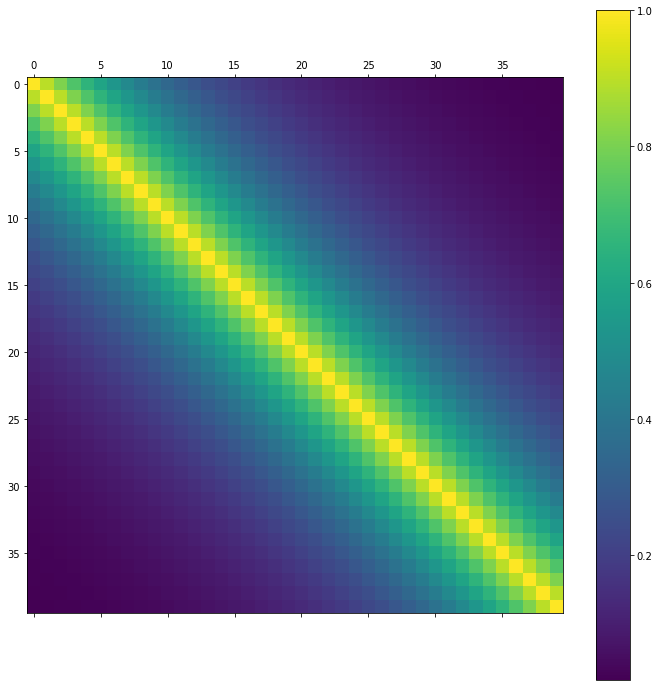

In [68]:
plt.figure(figsize=[12,12])
plt.matshow(cova, fignum=1)
plt.colorbar()

Text(0, 0.5, 'Measurement')

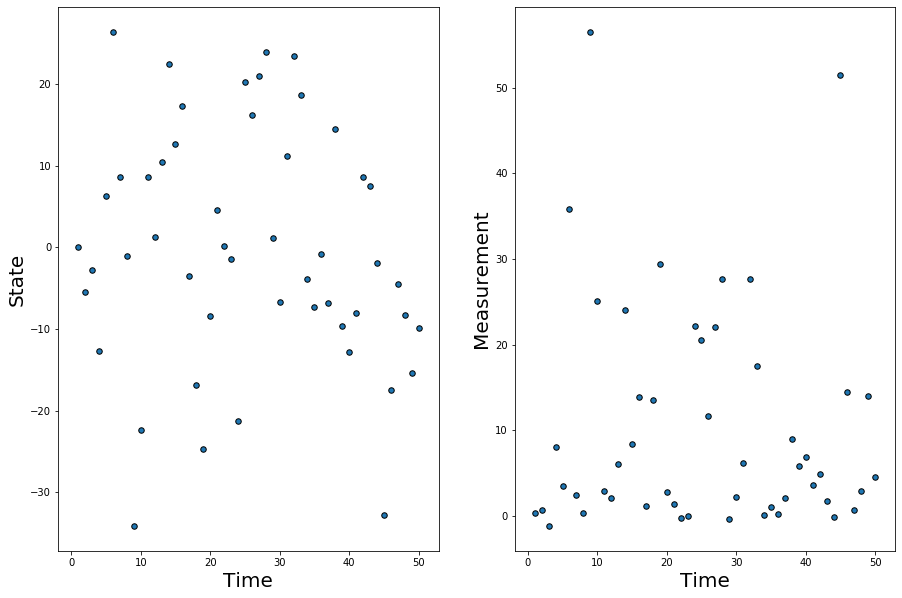

In [106]:
times = np.array(range(1, 51))
initial_state = 0
states = np.zeros([1, 50])
measurements = np.zeros_like(states)
for iTime, time in enumerate(times):
    if time == 1:
        states[:, iTime] = initial_state
    else:
        states[:, iTime] = evolution(states[0, iTime - 1], time)
    measurements[:, iTime] = measurement_model(states[0, iTime])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = [15, 10])
ax[0].scatter(times, states[0], edgecolors = 'black', s = 30)
ax[1].scatter(times, measurements[0], edgecolors = 'black', s = 30)
for axis in ax:
    axis.set_xlabel("Time", fontsize = 20)

ax[0].set_ylabel("State", fontsize = 20)
ax[1].set_ylabel("Measurement", fontsize = 20)